In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohitbohra2994","key":"b7947860e2ad40758c4dac7cbd51c8ff"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d pankajkarki/humana



!ls

 98% 83.0M/84.5M [00:00<00:00, 74.3MB/s]
100% 84.5M/84.5M [00:00<00:00, 96.4MB/s]
humana.zip  kaggle.json  sample_data


In [4]:
!unzip humana.zip


Archive:  humana.zip
   creating: HAR/UCI_HAR_Dataset/
  inflating: HAR/UCI_HAR_Dataset/.DS_Store  
  inflating: HAR/UCI_HAR_Dataset/_DS_Store  
  inflating: HAR/UCI_HAR_Dataset/activity_labels.txt  
   creating: HAR/UCI_HAR_Dataset/csv_files/
  inflating: HAR/UCI_HAR_Dataset/csv_files/test.csv  
  inflating: HAR/UCI_HAR_Dataset/csv_files/train.csv  
  inflating: HAR/UCI_HAR_Dataset/features.txt  
  inflating: HAR/UCI_HAR_Dataset/features_info.txt  
  inflating: HAR/UCI_HAR_Dataset/README.txt  
   creating: HAR/UCI_HAR_Dataset/test/
   creating: HAR/UCI_HAR_Dataset/test/Inertial Signals/
  inflating: HAR/UCI_HAR_Dataset/test/Inertial Signals/body_acc_x_test.txt  
  inflating: HAR/UCI_HAR_Dataset/test/Inertial Signals/body_acc_y_test.txt  
  inflating: HAR/UCI_HAR_Dataset/test/Inertial Signals/body_acc_z_test.txt  
  inflating: HAR/UCI_HAR_Dataset/test/Inertial Signals/body_gyro_x_test.txt  
  inflating: HAR/UCI_HAR_Dataset/test/Inertial Signals/body_gyro_y_test.txt  
  inflating: HAR/U

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [12]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = 32

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
X_train.shape

(7352, 128, 9)

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [0]:
def create_model(neurons,dropout_rate):
	# create model
	model = Sequential()
	model.add(LSTM(neurons, input_shape=(timesteps, input_dim)))
	model.add(Dropout(dropout_rate))
	model.add(Dense(n_classes, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
	return model

In [0]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=50, verbose=1)

In [0]:
neurons = [48, 128]
dropout_rate = [0.3, 0.5, 0.7]
param_grid = dict(neurons=neurons,dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

In [0]:
#grid_result = grid.fit(X_train, Y_train)
grid_result  = grid.fit(X_train,
                           Y_train,
                           validation_data=(X_test, Y_test))



Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 4901 samples, validate on 2947 samples
Epoch 1/50
4901/4901 [==============================] - 10s 2ms/step - loss: 1.5194 - acc: 0.3758 - val_loss: 1.3882 - val_acc: 0.3485
Epoch 2/50
4901/4901 [==============================] - 9s 2ms/step - loss: 1.2841 - acc: 0.4756 - val_loss: 1.2731 - val_acc: 0.4418
Epoch 3/50
4901/4901 [==============================] - 9s 2ms/step - loss: 1.1908 - acc: 0.4915 - val_loss: 1.2457 - val_acc: 0.4102
Epoch 4/50
4901/4901 [==============================] - 9s 2ms/step - loss: 1.1570 - acc: 0.4779 - val_loss: 1.2479 - val_acc: 0.4102
Epoch 5/50
4901/4901 [==============================] - 9s 2ms/step - loss: 1.1365 - acc: 0.4795 - val_loss: 1.2611 - val_acc: 0.3997
Epoch 6/50
4901/4901 [==============================] - 9s 2ms/step - loss: 1.0653 - acc: 0.4974 - val_loss: 1.1544 - 

In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.918662 using {'dropout_rate': 0.3, 'neurons': 128}
0.906556 (0.028098) with: {'dropout_rate': 0.3, 'neurons': 48}
0.918662 (0.021173) with: {'dropout_rate': 0.3, 'neurons': 128}
0.840588 (0.070673) with: {'dropout_rate': 0.5, 'neurons': 48}
0.906012 (0.020110) with: {'dropout_rate': 0.5, 'neurons': 128}
0.838683 (0.018163) with: {'dropout_rate': 0.7, 'neurons': 48}
0.676823 (0.365888) with: {'dropout_rate': 0.7, 'neurons': 128}


In [0]:
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.3))
model.add(Dense(n_classes, kernel_initializer='uniform', activation='sigmoid'))
	
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=50 ,verbose=1,validation_data=(X_test, Y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 34s 5ms/step - loss: 1.3822 - acc: 0.3678 - val_loss: 1.3504 - val_acc: 0.3488
Epoch 2/50
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2827 - acc: 0.4377 - val_loss: 1.2654 - val_acc: 0.4228
Epoch 3/50
7352/7352 [==============================] - 31s 4ms/step - loss: 1.1996 - acc: 0.4763 - val_loss: 1.1816 - val_acc: 0.5331
Epoch 4/50
7352/7352 [==============================] - 31s 4ms/step - loss: 1.0573 - acc: 0.5480 - val_loss: 2.7875 - val_acc: 0.3610
Epoch 5/50
7352/7352 [==============================] - 30s 4ms/step - loss: 1.0358 - acc: 0.5532 - val_loss: 1.7124 - val_acc: 0.4031
Epoch 6/50
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9561 - acc: 0.5793 - val_loss: 1.0400 - val_acc: 0.5137
Epoch 7/50
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7865 - acc: 0.6328 - val_loss: 0.8755 - val_acc: 0.6267
Epoch 8

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

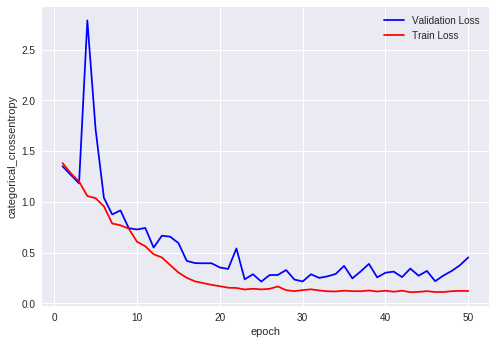

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,50+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [17]:
def create_model(neuron1,neuron2,dropout_rate1,dropout_rate2):
    model = Sequential()
    model.add(LSTM(neuron1,return_sequences=True,input_shape=(timesteps, input_dim)))
    model.add(Dropout(dropout_rate1))
    model.add(LSTM(neuron2))
    model.add(Dropout(dropout_rate2))
    model.add(Dense(n_classes, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model

In [22]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=50, verbose=1)

In [23]:
neuron1 = [48, 128]
neuron2 =[64,128]
dropout_rate1 = [0.3, 0.5, 0.7]
dropout_rate2 = [0.3, 0.5, 0.7]
param_grid = dict(neuron1=neuron1,neuron2=neuron2,dropout_rate1=dropout_rate1,dropout_rate2=dropout_rate2)
grid = GridSearchCV(estimator=model, param_grid=param_grid)

# Could not execute the above code because of less computational power

In [ ]:
#grid_result = grid.fit(X_train, Y_train)
grid_result  = grid.fit(X_train,
                           Y_train,
                           validation_data=(X_test, Y_test))


/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 54s 11ms/step - loss: 1.4528 - acc: 0.3738 - val_loss: 1.4074 - val_acc: 0.3536
Epoch 2/30
4901/4901 [==============================] - 33s 7ms/step - loss: 1.3322 - acc: 0.3920 - val_loss: 1.4159 - val_acc: 0.3532
Epoch 3/30
4901/4901 [==============================] - 35s 7ms/step - loss: 1.3022 - acc: 0.3920 - val_loss: 1.3624 - val_acc: 0.3539
Epoch 4/30
4901/4901 [==============================] - 34s 7ms/step - loss: 1.1838 - acc: 0.4603 - val_loss: 1.2859 - val_acc: 0.4096
Epoch 5/30
4901/4901 [==============================] - 34s 7ms/step - loss: 1.1343 - acc: 0.4795 - val_loss: 1.1412 - val_acc: 0.4425
Epoch 6/30
4901/4901 [==============================] - 33s 7ms/step - loss: 1.0555 - acc: 0.4821 - val_loss: 1.1022 - val_acc: 0.4401
Epoch 7/30
4901/4901 [==============================] - 33s 7ms/step - loss: 1.0730 - acc: 0.4913 - val_loss: 1.0627 - val_acc: 0.4418
Epoch 

Epoch 30/30
4901/4901 [==============================] - 7s 1ms/step
Train on 4902 samples, validate on 2947 samples
Epoch 1/30
4902/4902 [==============================] - 54s 11ms/step - loss: 1.4643 - acc: 0.3403 - val_loss: 1.4158 - val_acc: 0.3112
Epoch 2/30
4902/4902 [==============================] - 33s 7ms/step - loss: 1.2461 - acc: 0.4492 - val_loss: 1.2675 - val_acc: 0.4221
Epoch 3/30
4902/4902 [==============================] - 33s 7ms/step - loss: 1.0909 - acc: 0.5135 - val_loss: 1.0907 - val_acc: 0.4903
Epoch 4/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.9410 - acc: 0.5659 - val_loss: 1.3525 - val_acc: 0.4102
Epoch 5/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.8452 - acc: 0.6032 - val_loss: 1.5454 - val_acc: 0.4096
Epoch 6/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.7819 - acc: 0.6022 - val_loss: 0.8820 - val_acc: 0.5718
Epoch 7/30
4902/4902 [==============================] - 33s 7ms/step - l

Epoch 28/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1413 - acc: 0.9459 - val_loss: 0.4071 - val_acc: 0.8880
Epoch 29/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1415 - acc: 0.9469 - val_loss: 0.5049 - val_acc: 0.8670
Epoch 30/30
4901/4901 [==============================] - 10s 2ms/step
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 66s 14ms/step - loss: 1.2896 - acc: 0.4379 - val_loss: 1.5527 - val_acc: 0.3709
Epoch 2/30
4901/4901 [==============================] - 44s 9ms/step - loss: 1.1222 - acc: 0.4932 - val_loss: 1.5657 - val_acc: 0.3841
Epoch 3/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.9537 - acc: 0.5713 - val_loss: 1.4819 - val_acc: 0.4079
Epoch 4/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.7749 - acc: 0.6491 - val_loss: 0.8665 - val_acc: 0.6627
Epoch 5/30
4901/4901 [==============================] - 44s 9ms/step 

Epoch 26/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.1314 - acc: 0.9429 - val_loss: 0.5424 - val_acc: 0.8626
Epoch 27/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.1395 - acc: 0.9447 - val_loss: 0.4796 - val_acc: 0.8884
Epoch 28/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.1323 - acc: 0.9457 - val_loss: 0.4364 - val_acc: 0.8819
Epoch 29/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.1189 - acc: 0.9466 - val_loss: 0.4580 - val_acc: 0.8924
Epoch 30/30
4902/4902 [==============================] - 10s 2ms/step
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 77s 16ms/step - loss: 1.4429 - acc: 0.3799 - val_loss: 1.3435 - val_acc: 0.3627
Epoch 2/30
4901/4901 [==============================] - 55s 11ms/step - loss: 1.3153 - acc: 0.3918 - val_loss: 1.3261 - val_acc: 0.3627
Epoch 3/30
4901/4901 [==============================] - 55s 11ms/s

4901/4901 [==============================] - 55s 11ms/step - loss: 0.1727 - acc: 0.9441 - val_loss: 0.4688 - val_acc: 0.8768
Epoch 24/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1491 - acc: 0.9480 - val_loss: 0.3796 - val_acc: 0.8935
Epoch 25/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1529 - acc: 0.9459 - val_loss: 0.3732 - val_acc: 0.8884
Epoch 26/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1422 - acc: 0.9506 - val_loss: 0.4078 - val_acc: 0.8877
Epoch 27/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.1334 - acc: 0.9498 - val_loss: 0.7019 - val_acc: 0.8622
Epoch 28/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.2913 - acc: 0.9259 - val_loss: 0.4304 - val_acc: 0.8867
Epoch 29/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.1570 - acc: 0.9484 - val_loss: 0.5175 - val_acc: 0.8694
Epoch 30/30
4901/4901 [==============================

4901/4901 [==============================] - 70s 14ms/step - loss: 0.1677 - acc: 0.9347 - val_loss: 0.2597 - val_acc: 0.9080
Epoch 21/30
4901/4901 [==============================] - 70s 14ms/step - loss: 0.1656 - acc: 0.9378 - val_loss: 0.3598 - val_acc: 0.8894
Epoch 22/30
4901/4901 [==============================] - 70s 14ms/step - loss: 0.1499 - acc: 0.9437 - val_loss: 0.3029 - val_acc: 0.8962
Epoch 23/30
4901/4901 [==============================] - 70s 14ms/step - loss: 0.1626 - acc: 0.9343 - val_loss: 0.2987 - val_acc: 0.9097
Epoch 24/30
4901/4901 [==============================] - 70s 14ms/step - loss: 0.1420 - acc: 0.9472 - val_loss: 0.3521 - val_acc: 0.8901
Epoch 25/30
4901/4901 [==============================] - 70s 14ms/step - loss: 0.1341 - acc: 0.9504 - val_loss: 0.4418 - val_acc: 0.8918
Epoch 26/30
4901/4901 [==============================] - 70s 14ms/step - loss: 0.1359 - acc: 0.9482 - val_loss: 0.4162 - val_acc: 0.8850
Epoch 27/30
4901/4901 [==============================

4902/4902 [==============================] - 70s 14ms/step - loss: 0.1712 - acc: 0.9323 - val_loss: 0.5701 - val_acc: 0.8717
Epoch 18/30
4902/4902 [==============================] - 69s 14ms/step - loss: 0.1654 - acc: 0.9368 - val_loss: 0.4497 - val_acc: 0.8843
Epoch 19/30
4902/4902 [==============================] - 69s 14ms/step - loss: 0.1794 - acc: 0.9329 - val_loss: 0.5405 - val_acc: 0.8731
Epoch 20/30
4902/4902 [==============================] - 69s 14ms/step - loss: 0.1377 - acc: 0.9449 - val_loss: 0.4998 - val_acc: 0.8772
Epoch 21/30
4902/4902 [==============================] - 69s 14ms/step - loss: 0.1398 - acc: 0.9453 - val_loss: 0.3961 - val_acc: 0.9016
Epoch 22/30
4902/4902 [==============================] - 70s 14ms/step - loss: 0.1539 - acc: 0.9455 - val_loss: 0.4664 - val_acc: 0.8792
Epoch 23/30
4902/4902 [==============================] - 71s 14ms/step - loss: 0.1429 - acc: 0.9431 - val_loss: 0.4247 - val_acc: 0.9108
Epoch 24/30
4902/4902 [==============================

Epoch 15/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.4309 - acc: 0.7915 - val_loss: 0.6171 - val_acc: 0.7499
Epoch 16/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.4324 - acc: 0.7956 - val_loss: 0.7450 - val_acc: 0.7170
Epoch 17/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.4480 - acc: 0.7868 - val_loss: 0.5712 - val_acc: 0.7540
Epoch 18/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.4088 - acc: 0.7945 - val_loss: 0.5725 - val_acc: 0.7523
Epoch 19/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.3699 - acc: 0.8062 - val_loss: 0.5723 - val_acc: 0.7628
Epoch 20/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.3610 - acc: 0.8135 - val_loss: 0.5469 - val_acc: 0.7584
Epoch 21/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.4098 - acc: 0.8255 - val_loss: 0.9344 - val_acc: 0.7615
Epoch 22/30
4901/4901 [=========================

Epoch 13/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2844 - acc: 0.9063 - val_loss: 0.4229 - val_acc: 0.8700
Epoch 14/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2671 - acc: 0.9123 - val_loss: 0.3154 - val_acc: 0.8924
Epoch 15/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2383 - acc: 0.9235 - val_loss: 0.3492 - val_acc: 0.8799
Epoch 16/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2102 - acc: 0.9270 - val_loss: 0.4374 - val_acc: 0.8707
Epoch 17/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2126 - acc: 0.9249 - val_loss: 0.4424 - val_acc: 0.8327
Epoch 18/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2091 - acc: 0.9251 - val_loss: 0.3752 - val_acc: 0.8962
Epoch 19/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1988 - acc: 0.9333 - val_loss: 0.4095 - val_acc: 0.8714
Epoch 20/30
4901/4901 [=========================

Epoch 11/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.5146 - acc: 0.7574 - val_loss: 0.6628 - val_acc: 0.7234
Epoch 12/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.4754 - acc: 0.7778 - val_loss: 0.9321 - val_acc: 0.6651
Epoch 13/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.4218 - acc: 0.7885 - val_loss: 0.5861 - val_acc: 0.7329
Epoch 14/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.4098 - acc: 0.8072 - val_loss: 0.9602 - val_acc: 0.7106
Epoch 15/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.3728 - acc: 0.8437 - val_loss: 0.7288 - val_acc: 0.7662
Epoch 16/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.3409 - acc: 0.8752 - val_loss: 0.5372 - val_acc: 0.7788
Epoch 17/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.3139 - acc: 0.8868 - val_loss: 0.5227 - val_acc: 0.8439
Epoch 18/30
4902/4902 [=========================

Epoch 9/30
4901/4901 [==============================] - 55s 11ms/step - loss: 1.1953 - acc: 0.4538 - val_loss: 1.2515 - val_acc: 0.4432
Epoch 10/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.9424 - acc: 0.5715 - val_loss: 1.9176 - val_acc: 0.4072
Epoch 11/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.9485 - acc: 0.5658 - val_loss: 0.9397 - val_acc: 0.5572
Epoch 12/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.8150 - acc: 0.6242 - val_loss: 0.8724 - val_acc: 0.6050
Epoch 13/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.7170 - acc: 0.6539 - val_loss: 0.9237 - val_acc: 0.6010
Epoch 14/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.8673 - acc: 0.6154 - val_loss: 0.8108 - val_acc: 0.6664
Epoch 15/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.8705 - acc: 0.6048 - val_loss: 0.9372 - val_acc: 0.5860
Epoch 16/30
4901/4901 [===================

4901/4901 [==============================] - 68s 14ms/step - loss: 1.2739 - acc: 0.4285 - val_loss: 1.3274 - val_acc: 0.3570
Epoch 7/30
4901/4901 [==============================] - 69s 14ms/step - loss: 1.2943 - acc: 0.4097 - val_loss: 1.2377 - val_acc: 0.4513
Epoch 8/30
4901/4901 [==============================] - 69s 14ms/step - loss: 1.1620 - acc: 0.4770 - val_loss: 1.2839 - val_acc: 0.4119
Epoch 9/30
4901/4901 [==============================] - 69s 14ms/step - loss: 1.1394 - acc: 0.4948 - val_loss: 1.2401 - val_acc: 0.4499
Epoch 10/30
4901/4901 [==============================] - 69s 14ms/step - loss: 1.0991 - acc: 0.4997 - val_loss: 1.2768 - val_acc: 0.4204
Epoch 11/30
4901/4901 [==============================] - 76s 16ms/step - loss: 1.0791 - acc: 0.4995 - val_loss: 1.1219 - val_acc: 0.4493
Epoch 12/30
4901/4901 [==============================] - 71s 14ms/step - loss: 1.0416 - acc: 0.5036 - val_loss: 1.1146 - val_acc: 0.4557
Epoch 13/30
4901/4901 [==============================] -

4902/4902 [==============================] - 68s 14ms/step - loss: 1.0146 - acc: 0.5557 - val_loss: 1.1129 - val_acc: 0.5721
Epoch 4/30
4902/4902 [==============================] - 68s 14ms/step - loss: 1.0306 - acc: 0.5082 - val_loss: 1.0704 - val_acc: 0.5300
Epoch 5/30
4902/4902 [==============================] - 69s 14ms/step - loss: 0.8870 - acc: 0.5955 - val_loss: 0.8990 - val_acc: 0.6115
Epoch 6/30
4902/4902 [==============================] - 68s 14ms/step - loss: 0.7976 - acc: 0.6230 - val_loss: 0.8354 - val_acc: 0.5925
Epoch 7/30
4902/4902 [==============================] - 68s 14ms/step - loss: 0.8423 - acc: 0.5985 - val_loss: 1.0473 - val_acc: 0.4886
Epoch 8/30
4902/4902 [==============================] - 68s 14ms/step - loss: 0.7799 - acc: 0.5904 - val_loss: 0.8221 - val_acc: 0.6288
Epoch 9/30
4902/4902 [==============================] - 68s 14ms/step - loss: 0.7342 - acc: 0.6499 - val_loss: 0.8145 - val_acc: 0.6478
Epoch 10/30
4902/4902 [==============================] - 68

4901/4901 [==============================] - 62s 13ms/step - loss: 1.4827 - acc: 0.3514 - val_loss: 1.4583 - val_acc: 0.3288
Epoch 2/30
4901/4901 [==============================] - 33s 7ms/step - loss: 1.2759 - acc: 0.4332 - val_loss: 1.3240 - val_acc: 0.4605
Epoch 3/30
4901/4901 [==============================] - 33s 7ms/step - loss: 1.1172 - acc: 0.5313 - val_loss: 1.1519 - val_acc: 0.5165
Epoch 4/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.9868 - acc: 0.5754 - val_loss: 1.0269 - val_acc: 0.5222
Epoch 5/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.8988 - acc: 0.6201 - val_loss: 1.0487 - val_acc: 0.5416
Epoch 6/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.8637 - acc: 0.6223 - val_loss: 0.9136 - val_acc: 0.5694
Epoch 7/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.8213 - acc: 0.6250 - val_loss: 0.8522 - val_acc: 0.5813
Epoch 8/30
4901/4901 [==============================] - 33s 7ms/s

4902/4902 [==============================] - 7s 1ms/step
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 72s 15ms/step - loss: 1.3676 - acc: 0.4269 - val_loss: 1.3431 - val_acc: 0.4252
Epoch 2/30
4901/4901 [==============================] - 44s 9ms/step - loss: 1.1454 - acc: 0.4999 - val_loss: 1.1322 - val_acc: 0.4255
Epoch 3/30
4901/4901 [==============================] - 44s 9ms/step - loss: 1.0042 - acc: 0.5685 - val_loss: 1.6918 - val_acc: 0.3702
Epoch 4/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.8049 - acc: 0.5968 - val_loss: 0.7570 - val_acc: 0.6203
Epoch 5/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.8024 - acc: 0.6162 - val_loss: 1.0976 - val_acc: 0.4130
Epoch 6/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.7317 - acc: 0.6266 - val_loss: 0.7528 - val_acc: 0.6274
Epoch 7/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.7167 

4901/4901 [==============================] - 44s 9ms/step - loss: 0.1585 - acc: 0.9461 - val_loss: 0.9351 - val_acc: 0.8409
Epoch 29/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1574 - acc: 0.9433 - val_loss: 0.5228 - val_acc: 0.8548
Epoch 30/30
4901/4901 [==============================] - 10s 2ms/step
Train on 4902 samples, validate on 2947 samples
Epoch 1/30
4902/4902 [==============================] - 73s 15ms/step - loss: 1.3535 - acc: 0.4047 - val_loss: 1.2628 - val_acc: 0.4662
Epoch 2/30
4902/4902 [==============================] - 44s 9ms/step - loss: 1.0985 - acc: 0.5039 - val_loss: 1.1278 - val_acc: 0.4771
Epoch 3/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.8952 - acc: 0.5930 - val_loss: 0.8865 - val_acc: 0.5847
Epoch 4/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.8761 - acc: 0.5853 - val_loss: 0.8263 - val_acc: 0.6413
Epoch 5/30
4902/4902 [==============================] - 45s 9ms/step - loss: 0.71

Epoch 26/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.6518 - acc: 0.6750 - val_loss: 0.7496 - val_acc: 0.6278
Epoch 27/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.6558 - acc: 0.6678 - val_loss: 0.6973 - val_acc: 0.6274
Epoch 28/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.6081 - acc: 0.6770 - val_loss: 0.7703 - val_acc: 0.6172
Epoch 29/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.6815 - acc: 0.6623 - val_loss: 0.7847 - val_acc: 0.6179
Epoch 30/30
4901/4901 [==============================] - 13s 3ms/step
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 84s 17ms/step - loss: 1.4663 - acc: 0.3542 - val_loss: 1.4144 - val_acc: 0.3536
Epoch 2/30
4901/4901 [==============================] - 55s 11ms/step - loss: 1.3485 - acc: 0.3540 - val_loss: 1.4639 - val_acc: 0.3448
Epoch 3/30
4901/4901 [==============================] - 55s 11

4902/4902 [==============================] - 56s 11ms/step - loss: 0.5290 - acc: 0.6748 - val_loss: 0.7132 - val_acc: 0.6237
Epoch 24/30
4902/4902 [==============================] - 56s 11ms/step - loss: 0.5243 - acc: 0.6787 - val_loss: 0.6592 - val_acc: 0.6186
Epoch 25/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.5143 - acc: 0.6946 - val_loss: 0.7292 - val_acc: 0.6267
Epoch 26/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.4964 - acc: 0.7391 - val_loss: 1.0083 - val_acc: 0.6206
Epoch 27/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.4891 - acc: 0.7556 - val_loss: 0.7719 - val_acc: 0.7139
Epoch 28/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.4374 - acc: 0.7968 - val_loss: 0.5906 - val_acc: 0.7567
Epoch 29/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.4096 - acc: 0.8072 - val_loss: 0.6269 - val_acc: 0.7642
Epoch 30/30
4902/4902 [==============================

4901/4901 [==============================] - 69s 14ms/step - loss: 0.2094 - acc: 0.9325 - val_loss: 0.6449 - val_acc: 0.8565
Epoch 21/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1809 - acc: 0.9402 - val_loss: 0.7968 - val_acc: 0.8208
Epoch 22/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.2093 - acc: 0.9292 - val_loss: 0.6497 - val_acc: 0.8704
Epoch 23/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1571 - acc: 0.9459 - val_loss: 0.5102 - val_acc: 0.8911
Epoch 24/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.2387 - acc: 0.9341 - val_loss: 0.5108 - val_acc: 0.8806
Epoch 25/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1392 - acc: 0.9504 - val_loss: 0.5201 - val_acc: 0.8853
Epoch 26/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1721 - acc: 0.9482 - val_loss: 0.5398 - val_acc: 0.8833
Epoch 27/30
4901/4901 [==============================

Epoch 18/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.2914 - acc: 0.8986 - val_loss: 0.7484 - val_acc: 0.7682
Epoch 19/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.3023 - acc: 0.9161 - val_loss: 0.5105 - val_acc: 0.8656
Epoch 20/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.2363 - acc: 0.9343 - val_loss: 0.4249 - val_acc: 0.8337
Epoch 21/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.1760 - acc: 0.9388 - val_loss: 0.3587 - val_acc: 0.8863
Epoch 22/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.1834 - acc: 0.9376 - val_loss: 0.5571 - val_acc: 0.8402
Epoch 23/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.1590 - acc: 0.9453 - val_loss: 0.5395 - val_acc: 0.8554
Epoch 24/30
4901/4901 [==============================] - 33s 7ms/step - loss: 0.2009 - acc: 0.9349 - val_loss: 0.5306 - val_acc: 0.8700
Epoch 25/30
4901/4901 [=========================

Epoch 16/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.8479 - acc: 0.6493 - val_loss: 0.7381 - val_acc: 0.7150
Epoch 17/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.6165 - acc: 0.7264 - val_loss: 0.7191 - val_acc: 0.7129
Epoch 18/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.5735 - acc: 0.7377 - val_loss: 0.9271 - val_acc: 0.6013
Epoch 19/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.5647 - acc: 0.7346 - val_loss: 0.6936 - val_acc: 0.6654
Epoch 20/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.4700 - acc: 0.7652 - val_loss: 0.7120 - val_acc: 0.7048
Epoch 21/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.4584 - acc: 0.7968 - val_loss: 0.5363 - val_acc: 0.8062
Epoch 22/30
4902/4902 [==============================] - 34s 7ms/step - loss: 0.3786 - acc: 0.8554 - val_loss: 0.8443 - val_acc: 0.6624
Epoch 23/30
4902/4902 [=========================

Epoch 14/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.2239 - acc: 0.9257 - val_loss: 0.4959 - val_acc: 0.8673
Epoch 15/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1762 - acc: 0.9370 - val_loss: 0.5167 - val_acc: 0.8690
Epoch 16/30
4901/4901 [==============================] - 45s 9ms/step - loss: 0.1494 - acc: 0.9461 - val_loss: 0.6295 - val_acc: 0.8694
Epoch 17/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1497 - acc: 0.9500 - val_loss: 0.5430 - val_acc: 0.8592
Epoch 18/30
4901/4901 [==============================] - 46s 9ms/step - loss: 0.1489 - acc: 0.9469 - val_loss: 0.5043 - val_acc: 0.8768
Epoch 19/30
4901/4901 [==============================] - 45s 9ms/step - loss: 0.1443 - acc: 0.9463 - val_loss: 0.5952 - val_acc: 0.8717
Epoch 20/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.1250 - acc: 0.9553 - val_loss: 0.4851 - val_acc: 0.8853
Epoch 21/30
4901/4901 [=========================

Epoch 12/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.6849 - acc: 0.6415 - val_loss: 0.7623 - val_acc: 0.6166
Epoch 13/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.6718 - acc: 0.6515 - val_loss: 0.8544 - val_acc: 0.5847
Epoch 14/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.7088 - acc: 0.6337 - val_loss: 0.7583 - val_acc: 0.6223
Epoch 15/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.5929 - acc: 0.6868 - val_loss: 0.7695 - val_acc: 0.6427
Epoch 16/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.5948 - acc: 0.7343 - val_loss: 0.6684 - val_acc: 0.7438
Epoch 17/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.5062 - acc: 0.8092 - val_loss: 0.6543 - val_acc: 0.7591
Epoch 18/30
4901/4901 [==============================] - 54s 11ms/step - loss: 0.4169 - acc: 0.8351 - val_loss: 0.5517 - val_acc: 0.7961
Epoch 19/30
4901/4901 [==================

4902/4902 [==============================] - 55s 11ms/step - loss: 1.2116 - acc: 0.4410 - val_loss: 1.2986 - val_acc: 0.4048
Epoch 10/30
4902/4902 [==============================] - 55s 11ms/step - loss: 1.1570 - acc: 0.4543 - val_loss: 1.2759 - val_acc: 0.3984
Epoch 11/30
4902/4902 [==============================] - 55s 11ms/step - loss: 1.1410 - acc: 0.4670 - val_loss: 2.0132 - val_acc: 0.2796
Epoch 12/30
4902/4902 [==============================] - 55s 11ms/step - loss: 1.1832 - acc: 0.4317 - val_loss: 1.5093 - val_acc: 0.4350
Epoch 13/30
4902/4902 [==============================] - 55s 11ms/step - loss: 1.0611 - acc: 0.4853 - val_loss: 1.1958 - val_acc: 0.4343
Epoch 14/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.9482 - acc: 0.5467 - val_loss: 1.2660 - val_acc: 0.4309
Epoch 15/30
4902/4902 [==============================] - 55s 11ms/step - loss: 0.8885 - acc: 0.5985 - val_loss: 1.0955 - val_acc: 0.5314
Epoch 16/30
4902/4902 [==============================

4901/4901 [==============================] - 68s 14ms/step - loss: 0.8534 - acc: 0.6276 - val_loss: 0.8675 - val_acc: 0.6318
Epoch 7/30
4901/4901 [==============================] - 68s 14ms/step - loss: 0.7221 - acc: 0.6862 - val_loss: 1.7167 - val_acc: 0.4255
Epoch 8/30
4901/4901 [==============================] - 68s 14ms/step - loss: 0.7200 - acc: 0.7092 - val_loss: 1.1100 - val_acc: 0.5986
Epoch 9/30
4901/4901 [==============================] - 68s 14ms/step - loss: 0.6561 - acc: 0.7272 - val_loss: 0.7405 - val_acc: 0.7245
Epoch 10/30
4901/4901 [==============================] - 68s 14ms/step - loss: 0.5395 - acc: 0.7756 - val_loss: 0.6479 - val_acc: 0.7472
Epoch 11/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.4057 - acc: 0.8513 - val_loss: 0.7330 - val_acc: 0.7638
Epoch 12/30
4901/4901 [==============================] - 68s 14ms/step - loss: 0.2683 - acc: 0.9190 - val_loss: 0.5367 - val_acc: 0.8544
Epoch 13/30
4901/4901 [==============================] -

4901/4901 [==============================] - 34s 7ms/step - loss: 1.1968 - acc: 0.4630 - val_loss: 1.2106 - val_acc: 0.4313
Epoch 4/30
4901/4901 [==============================] - 34s 7ms/step - loss: 1.0841 - acc: 0.4756 - val_loss: 1.0718 - val_acc: 0.4462
Epoch 5/30
4901/4901 [==============================] - 34s 7ms/step - loss: 1.0437 - acc: 0.4879 - val_loss: 1.1103 - val_acc: 0.4225
Epoch 6/30
4901/4901 [==============================] - 34s 7ms/step - loss: 0.9708 - acc: 0.5046 - val_loss: 0.9687 - val_acc: 0.4153
Epoch 7/30
4901/4901 [==============================] - 34s 7ms/step - loss: 0.9281 - acc: 0.5525 - val_loss: 0.9959 - val_acc: 0.5395
Epoch 8/30
4901/4901 [==============================] - 34s 7ms/step - loss: 0.9449 - acc: 0.5711 - val_loss: 0.9365 - val_acc: 0.5976
Epoch 9/30
4901/4901 [==============================] - 34s 7ms/step - loss: 0.8530 - acc: 0.6119 - val_loss: 1.0716 - val_acc: 0.5059
Epoch 10/30
4901/4901 [==============================] - 34s 7ms/s

4902/4902 [==============================] - 71s 15ms/step - loss: 1.4434 - acc: 0.3986 - val_loss: 1.3655 - val_acc: 0.3702
Epoch 2/30
4902/4902 [==============================] - 33s 7ms/step - loss: 1.1789 - acc: 0.4757 - val_loss: 1.3072 - val_acc: 0.4377
Epoch 3/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.9939 - acc: 0.5610 - val_loss: 1.0464 - val_acc: 0.5199
Epoch 4/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.9068 - acc: 0.6261 - val_loss: 1.0851 - val_acc: 0.5141
Epoch 5/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.8245 - acc: 0.6308 - val_loss: 0.7797 - val_acc: 0.6705
Epoch 6/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.7295 - acc: 0.6722 - val_loss: 0.9028 - val_acc: 0.6356
Epoch 7/30
4902/4902 [==============================] - 33s 7ms/step - loss: 0.7050 - acc: 0.6797 - val_loss: 0.6915 - val_acc: 0.7187
Epoch 8/30
4902/4902 [==============================] - 33s 7ms/s

4901/4901 [==============================] - 10s 2ms/step
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 87s 18ms/step - loss: 1.3710 - acc: 0.4220 - val_loss: 1.2302 - val_acc: 0.4459
Epoch 2/30
4901/4901 [==============================] - 45s 9ms/step - loss: 1.1132 - acc: 0.4936 - val_loss: 1.2043 - val_acc: 0.4381
Epoch 3/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.9859 - acc: 0.5670 - val_loss: 1.0423 - val_acc: 0.5422
Epoch 4/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.8836 - acc: 0.5858 - val_loss: 0.8841 - val_acc: 0.5928
Epoch 5/30
4901/4901 [==============================] - 45s 9ms/step - loss: 0.7722 - acc: 0.6264 - val_loss: 0.8229 - val_acc: 0.6478
Epoch 6/30
4901/4901 [==============================] - 44s 9ms/step - loss: 0.6723 - acc: 0.6701 - val_loss: 0.7674 - val_acc: 0.6064
Epoch 7/30
4901/4901 [==============================] - 45s 9ms/step - loss: 0.6024

4902/4902 [==============================] - 45s 9ms/step - loss: 0.1307 - acc: 0.9390 - val_loss: 0.3861 - val_acc: 0.8901
Epoch 29/30
4902/4902 [==============================] - 44s 9ms/step - loss: 0.1236 - acc: 0.9498 - val_loss: 0.3399 - val_acc: 0.8918
Epoch 30/30
4902/4902 [==============================] - 10s 2ms/step
Train on 4901 samples, validate on 2947 samples
Epoch 1/30
4901/4901 [==============================] - 95s 19ms/step - loss: 1.4942 - acc: 0.3646 - val_loss: 1.4159 - val_acc: 0.3536
Epoch 2/30
4901/4901 [==============================] - 55s 11ms/step - loss: 1.7309 - acc: 0.3399 - val_loss: 2.1672 - val_acc: 0.1849
Epoch 3/30
4901/4901 [==============================] - 55s 11ms/step - loss: 1.4829 - acc: 0.3530 - val_loss: 1.3805 - val_acc: 0.3536
Epoch 4/30
4901/4901 [==============================] - 55s 11ms/step - loss: 1.3323 - acc: 0.3909 - val_loss: 1.3237 - val_acc: 0.3627
Epoch 5/30
4901/4901 [==============================] - 55s 11ms/step - loss: 

4901/4901 [==============================] - 56s 11ms/step - loss: 0.2020 - acc: 0.9400 - val_loss: 0.4007 - val_acc: 0.8931
Epoch 26/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1663 - acc: 0.9429 - val_loss: 0.4796 - val_acc: 0.8812
Epoch 27/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1637 - acc: 0.9435 - val_loss: 0.4804 - val_acc: 0.8839
Epoch 28/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1385 - acc: 0.9506 - val_loss: 0.4263 - val_acc: 0.8968
Epoch 29/30
4901/4901 [==============================] - 55s 11ms/step - loss: 0.1687 - acc: 0.9421 - val_loss: 0.4983 - val_acc: 0.8870
Epoch 30/30
4901/4901 [==============================] - 13s 3ms/step
Train on 4902 samples, validate on 2947 samples
Epoch 1/30
4902/4902 [==============================] - 100s 20ms/step - loss: 1.5691 - acc: 0.3411 - val_loss: 1.4012 - val_acc: 0.3573
Epoch 2/30
4902/4902 [==============================] - 55s 11ms/step - 

4901/4901 [==============================] - 69s 14ms/step - loss: 0.1612 - acc: 0.9384 - val_loss: 0.3781 - val_acc: 0.8962
Epoch 23/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1561 - acc: 0.9451 - val_loss: 0.4440 - val_acc: 0.8744
Epoch 24/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1533 - acc: 0.9418 - val_loss: 0.4460 - val_acc: 0.8802
Epoch 25/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1580 - acc: 0.9312 - val_loss: 0.6202 - val_acc: 0.8504
Epoch 26/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1439 - acc: 0.9480 - val_loss: 0.4002 - val_acc: 0.8938
Epoch 27/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1616 - acc: 0.9453 - val_loss: 0.6025 - val_acc: 0.8697
Epoch 28/30
4901/4901 [==============================] - 69s 14ms/step - loss: 0.1404 - acc: 0.9469 - val_loss: 0.5905 - val_acc: 0.8476
Epoch 29/30
4901/4901 [==============================

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [25]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm



model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(timesteps, input_dim)))
model.add(Dropout(0.7))
model.add(LSTM(256))
model.add(Dropout(0.7))
model.add(Dense(n_classes,kernel_initializer='uniform',activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 128)          70656     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1542      
Total params: 466,438
Trainable params: 466,438
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(X_train, Y_train, nb_epoch=50, batch_size=50 ,verbose=1,validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 138s 19ms/step - loss: 1.3694 - acc: 0.3945 - val_loss: 2.2371 - val_acc: 0.2284
Epoch 2/50
7352/7352 [==============================] - 139s 19ms/step - loss: 1.1898 - acc: 0.4497 - val_loss: 1.0940 - val_acc: 0.5239
Epoch 3/50
7352/7352 [==============================] - 135s 18ms/step - loss: 0.9724 - acc: 0.5335 - val_loss: 1.0509 - val_acc: 0.5707
Epoch 4/50
7352/7352 [==============================] - 134s 18ms/step - loss: 0.8199 - acc: 0.6035 - val_loss: 0.8872 - val_acc: 0.5898
Epoch 5/50
7352/7352 [==============================] - 137s 19ms/step - loss: 0.7409 - acc: 0.6357 - val_loss: 0.8779 - val_acc: 0.6305
Epoch 6/50
7352/7352 [==============================] - 136s 18ms/step - loss: 0.6975 - acc: 0.6594 - val_loss: 0.8771 - val_acc: 0.5728
Epoch 7/50
7352/7352 [==============================] - 136s 19ms/step - loss: 0.6736 - acc: 0.6814 - val_loss: 0.8874 - val_acc: 

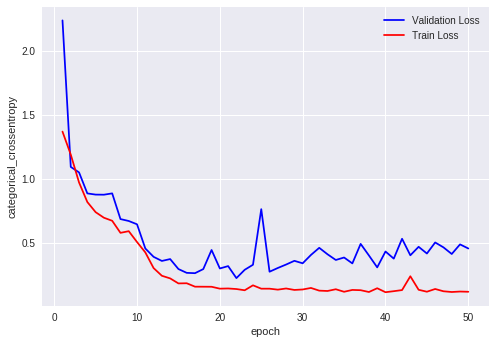

In [29]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('categorical_crossentropy')

# list of epoch numbers
x = list(range(1,50+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["No. of hidden layers","No. of neurons in layer 1","No. of neurons in layer 2","Dropout rate", "Train Score", "Test Score"]

x.add_row([1,128,"None", 0.3, 0.9535, 0.8996])
x.add_row([2,128,256, 0.7, 0.9525, 0.9101])

print(x)

+----------------------+---------------------------+---------------------------+--------------+-------------+------------+
| No. of hidden layers | No. of neurons in layer 1 | No. of neurons in layer 2 | Dropout rate | Train Score | Test Score |
+----------------------+---------------------------+---------------------------+--------------+-------------+------------+
|          1           |            128            |            None           |     0.3      |    0.9535   |   0.8996   |
|          2           |            128            |            256            |     0.7      |    0.9525   |   0.9101   |
+----------------------+---------------------------+---------------------------+--------------+-------------+------------+


### There are a total of two LSTM models. One with a single layer of LSTM and Another with 2 layered LSTM layers.

## 1 layered model

    1. For one layered LSTM model Hyperparameter tuning was done for number of neurons and dropout rates.

    2. The number of neurons to selesct from were 48,128  neurons.
    
    3. The dropout rate for the model were 0.3, 0.5, 0.7


## 2 layered model

    1. The number of neurons for first layer is 128 with a dropout rate of 0.7 
    
    2. The number of neurons for second layer is 256 with a dropout rate of 0.7

# CONCLUSION

1) For single LSTM model, best hyperparameter was found to be of 128 neurons and 0.3 dropout rate. The Trainscore is 95.35% and Test score is 89.96%

2) The Train score is 96.8% and Test score us 92.98%



